# **NLP project. Fake News detection** 

## **Basic imports** ##

In [1]:
import common as cm
import matplotlib.pyplot as plt

## **Loading datasets** ##

In [2]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 500)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 500)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [3]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [8]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

## **Preprocessing datasets** ##

In [9]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
import torch

def clean_data(X, y):
    # Changing labels from text to 0 and 1
    y[y['target']=='Fake'] = 0
    y[y['target']=='True'] = 1
    y['target'] = y['target'].values.astype(int)
    
    # Dropping redundant columns - date
    X = X.drop(columns=['title', 'subject', 'date'])

    # Each article labeled as True is taken from Reuters and has 'city (Reuters) - ' on the beggining. We need to eliminate it!
    X.loc[y['target']==1, 'text'] = X.loc[y['target']==1, 'text'].apply(lambda x: ' '.join(x.split()[x.split().index('(Reuters)')+2:]) if '(Reuters)' in x.split() else x)
    return X, y

# Generate contextual word embeddings
def generate_features(X):
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_mask = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:,0,:].numpy()

    return features

def create_SWE(X):
    # TODO
    return

def create_TF_IDF(X):
    # TODO
    return

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [10]:
X_train_pre, y_train_pre = clean_data(X_train, y_train)
X_test_pre, y_test_pre = clean_data(X_test, y_test)

In [11]:
X_train_features = generate_features(X_train_pre)
X_test_features = generate_features(X_test_pre)

## **Necessary imports** ##

In [12]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [13]:
def display_metrics(model, y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = model.classes_), display_labels=model.classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

## **Model 1 - SVM** ##

In [14]:
svm = SVC()
svm.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Accuracy: 0.925
F1 score: 0.9261083743842364


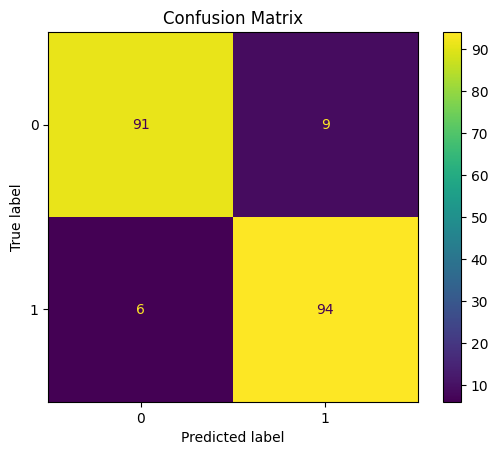

In [15]:
pred = svm.predict(X_test_features)
display_metrics(svm, y_test_pre, pred)

## **Model 2 - Logistic Regression**

In [16]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Accuracy: 0.95
F1 score: 0.95


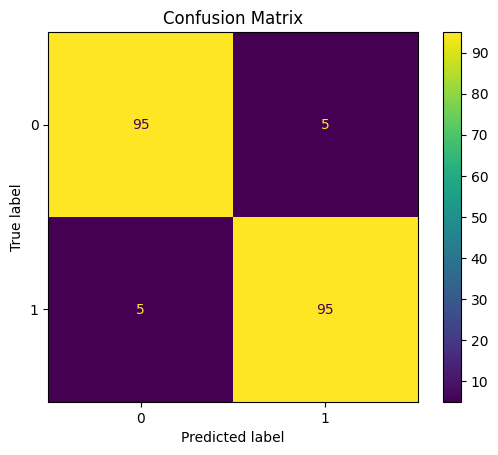

In [17]:
pred = lr_clf.predict(X_test_features)
display_metrics(lr_clf, y_test_pre, pred)

## **Model 3 - kNN**

In [18]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

Accuracy: 0.92
F1 score: 0.9207920792079208


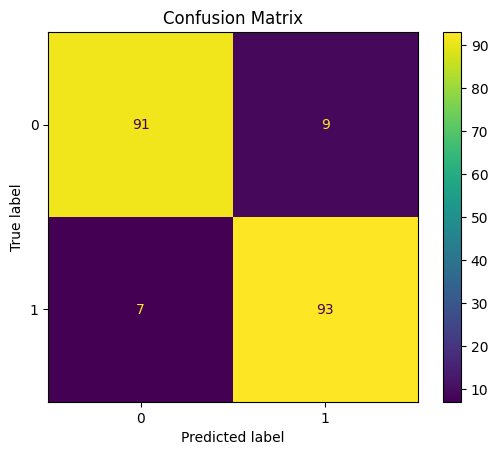

In [19]:
pred = knn.predict(X_test_features)
display_metrics(knn, y_test_pre, pred)

## **Model 4 - Decision Tree** ##

In [20]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_features, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.835
F1 score: 0.8324873096446701


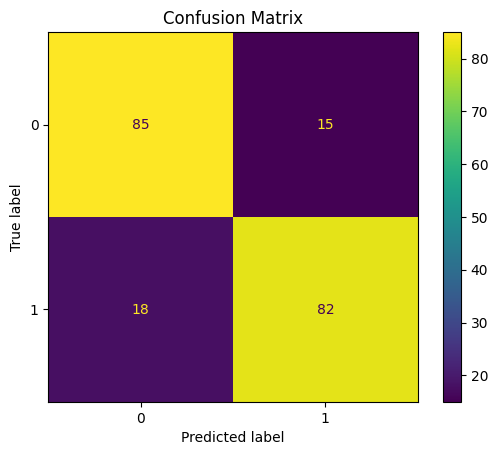

In [21]:
pred = tree_clf.predict(X_test_features)
display_metrics(tree_clf, y_test_pre, pred)

## **Model 5 - Random Forests** ##

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

Accuracy: 0.9
F1 score: 0.900990099009901


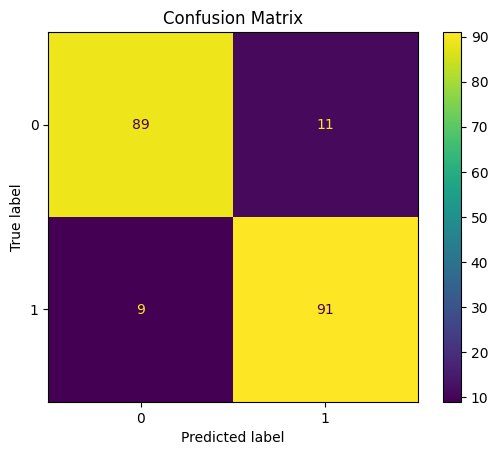

In [23]:
pred = rf.predict(X_test_features)
display_metrics(tree_clf, y_test_pre, pred)

## **Model 6 - Neural Network**